# Assessment 02

Eurico Martins (nº. 8794, a8794@alunos.ipca.pt)
Gutelvam Fernandes (nº. 33791,  a33791@alunos.ipca.pt)

In [1]:
%pip install tabulate
%pip install scikit-learn
%pip install mlxtend

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
from enum import Enum

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.svm import SVR, SVC
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from sklearn.metrics import confusion_matrix, silhouette_samples
from tabulate import tabulate

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from mlxtend.frequent_patterns import apriori, association_rules


from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    accuracy_score,
    confusion_matrix,
    precision_score,
    recall_score,
)


In [3]:
import warnings
warnings.filterwarnings('ignore')
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

## Data Preparation

In [4]:
class MissingValuesStrategy(Enum):
	MEAN="mean"
	MEDIAN = "median"
	MODE = "mode"
	CONSTANT = "constant"

In [5]:
class DataClassification(Enum):
	NUMERICAL = "numerical"
	CATEGORICAL = "categorical"

In [6]:
class DataPreparation:
	def __init__(self, file_path=None, target_column=None):
		if not file_path:
			raise ValueError("Either 'file_path' or 'dataframe' must be provided.")

		self.df = pd.read_csv(file_path)
		self.summary()
		
		self.original_df = self.df.copy(True)
		self.target_column = target_column

		if self.target_column and self.target_column not in self.df.columns:
			raise ValueError(f"Target column '{target_column}' not found in the dataset.")
		

	def drop_columns(self, columns_to_drop):
		if not isinstance(columns_to_drop, list):
				raise ValueError("columns_to_drop should be a list of column names.")

		# Check if any columns in the list do not exist in the DataFrame
		existing_columns = [col for col in columns_to_drop if col in self.df.columns]

		# Drop the columns from the DataFrame
		if existing_columns:
				self.df.drop(columns=existing_columns, inplace=True)
				print(f"Columns {', '.join(existing_columns)} dropped successfully.")


	def handle_missing_values(self,
													data_type: DataClassification = DataClassification.NUMERICAL,
													strategy:MissingValuesStrategy = MissingValuesStrategy.MEAN,
													fill_value=None,
													missing_threshold=None):
		
		if missing_threshold is not None:
			if not (0 <= missing_threshold <= 1):
				raise ValueError("missing_threshold must be a float between 0 and 1.")

			# Identify columns exceeding the missing threshold
			missing_percentages = self.df.isnull().mean()
			columns_to_drop = missing_percentages[missing_percentages > missing_threshold].index.tolist()
			if columns_to_drop:
				self.df.drop(columns=columns_to_drop, inplace=True)
				print(f"Dropped columns exceeding {missing_threshold*100:.2f}% missing data: {columns_to_drop}")
	
		for column in self.df.columns:
			if self.df[column].isnull().sum() > 0:				
				if data_type != DataClassification.CATEGORICAL and strategy == MissingValuesStrategy.MEAN and self.df[column].dtype in ["float64", "int64"]:
					self.df[column].fillna(self.df[column].mean(), inplace=True)
				elif data_type != DataClassification.CATEGORICAL and strategy == MissingValuesStrategy.MEDIAN and self.df[column].dtype in ["float64", "int64"]:
					self.df[column].fillna(self.df[column].median(), inplace=True)
				elif strategy == MissingValuesStrategy.MODE:
					self.df[column].fillna(self.df[column].mode()[0], inplace=True)
				elif strategy == MissingValuesStrategy.CONSTANT:
					self.df[column].fillna(fill_value, inplace=True)


	def encode_categorical(self, drop_first=True, prefix_sep="_"):
		categorical_columns = self.df.select_dtypes(include=["object", "category"]).columns
		
		if not categorical_columns.any():
				print("No categorical columns to encode.")
				return

		# One-hot encoding using pandas get_dummies
		self.df = pd.get_dummies(self.df, columns=categorical_columns, drop_first=drop_first, prefix_sep=prefix_sep)
		print(f"One-hot encoding applied to columns: {', '.join(categorical_columns)}")



	def get_features_and_target(self):
		if not self.target_column:
			raise ValueError("Target column is not specified.")
		X = self.df.drop(columns=[self.target_column])
		y = self.df[self.target_column]
		return X, y


	def scale_features(self):
		columns = self.df.select_dtypes(include=["float64", "int64"]).columns

		scaler = MinMaxScaler()
		self.df[columns] = scaler.fit_transform(self.df[columns])


	def remove_outliers(self, columns=None, factor=1.5, threshold=3):
		if columns is None:
			columns = self.df.select_dtypes(include=["float64", "int64"]).columns
		
		# Determine if the data is skewed or normal
		skewed_columns = self._detect_distribution(columns)
		if skewed_columns:
				print(f"Using IQR method for skewed columns: {skewed_columns}")
				rows_removed = self._remove_outliers_iqr(columns=skewed_columns, factor=factor)
		else:
				print("Using Z-score method for normally distributed columns.")
				rows_removed = self._remove_outliers_zscore(columns=columns, threshold=threshold)

		print(f"Rows removed: {rows_removed}")

	def remove_duplicates(self, subset=None, keep="first"):
		rows_before = len(self.df)
		self.df.drop_duplicates(subset=subset, keep=keep, inplace=True)
		rows_after = len(self.df)

		removed_rows = rows_before - rows_after
		print(f"Rows removed due to duplicates: {removed_rows}")
		return removed_rows


	def plot_distributions(self):
		# Distribution plots for numerical features
		numerical_columns = self.df.select_dtypes(include=["float64", "int64"]).columns
		n_cols = 3  # Number of plots in each row
		n_rows = (len(numerical_columns) // n_cols) + (1 if len(numerical_columns) % n_cols else 0)

		# Adjust the plot size
		plt.figure(figsize=(12, 4 * n_rows))
		for idx, column in enumerate(numerical_columns):
				plt.subplot(n_rows, n_cols, idx + 1)
				sns.histplot(self.df[column], kde=True, bins=30)
				plt.title(f'Distribution of {column}')
		# Apply tight layout for better spacing
		plt.tight_layout()
		plt.show()

	def normality_test_with_plots(self, columns=None):
		# Select all numerical columns if `columns` is None
		if columns is None:
			columns = self.df.select_dtypes(include=["int64", "float64"]).columns

		# Check if no columns are available for testing
		if columns.empty:
			print("No numerical columns to test.")
			return

		# Loop through each column
		for column in columns:
			print(f"\nNormality Tests for Column: {column}")

			# Perform Shapiro-Wilk Test
			stat_shapiro, p_value_shapiro = stats.shapiro(self.df[column].dropna())
			print(f"Shapiro-Wilk Test: statistic={stat_shapiro:.4f}, p-value={p_value_shapiro:.4f}")

			# Perform Kolmogorov-Smirnov Test
			stat_ks, p_value_ks = stats.kstest(
					self.df[column].dropna(), 
					'norm', 
					args=(self.df[column].mean(), self.df[column].std())
			)
			print(f"Kolmogorov-Smirnov Test: statistic={stat_ks:.4f}, p-value={p_value_ks:.4f}")

			# Calculate statistics
			mean_val = self.df[column].mean()
			median_val = self.df[column].median()
			mode_val = self.df[column].mode().iloc[0] if not self.df[column].mode().empty else None

			# Create subplots (1 row, 3 columns)
			_, axes = plt.subplots(1, 3, figsize=(18, 6))

			# Plot Histogram and KDE
			sns.histplot(self.df[column], kde=True, color='blue', bins=30, ax=axes[0], stat="density")
			axes[0].axvline(mean_val, color='red', linestyle='--', label=f"Mean: {mean_val:.2f}")
			axes[0].axvline(median_val, color='green', linestyle='--', label=f"Median: {median_val:.2f}")
			if mode_val is not None:
					axes[0].axvline(mode_val, color='purple', linestyle='--', label=f"Mode: {mode_val:.2f}")
			axes[0].legend()
			axes[0].set_title(f"Histogram and KDE of {column}", fontsize=14)
			axes[0].set_xlabel(column, fontsize=12)
			axes[0].set_ylabel("Density", fontsize=12)

			# Q-Q Plot
			stats.probplot(self.df[column].dropna(), dist="norm", plot=axes[1])
			axes[1].set_title(f"Q-Q Plot of {column}", fontsize=14)

			# Boxplot
			sns.boxplot(x=self.df[column], color='orange', ax=axes[2])
			axes[2].axvline(mean_val, color='red', linestyle='--', label=f"Mean: {mean_val:.2f}")
			axes[2].axvline(median_val, color='green', linestyle='--', label=f"Median: {median_val:.2f}")
			if mode_val is not None:
					axes[2].axvline(mode_val, color='purple', linestyle='--', label=f"Mode: {mode_val:.2f}")
			axes[2].legend()
			axes[2].set_title(f"Boxplot of {column}", fontsize=14)
			axes[2].set_xlabel(column, fontsize=12)

			# Adjust layout to avoid overlap
			plt.tight_layout()
			plt.show()

	def plot_correlation_matrix(self, columns=None, annot=True, cmap="coolwarm"):
		if columns is None:
			columns = self.df.select_dtypes(include=["float64", "int64"]).columns
		
		# Calculate the correlation matrix
		correlation_matrix = self.df[columns].corr()

		plt.figure(figsize=(10, 6))
		sns.heatmap(correlation_matrix, annot=annot, cmap=cmap, fmt='.2f', linewidths=0.5, cbar=True)
		plt.title("Correlation Matrix")
		plt.show()

	def normality_test(self, columns=None):
		if columns is None:
			columns = self.df.select_dtypes(include=["float64", "int64"]).columns
		
		for column in columns:
			stat_shapiro, p_value_shapiro = stats.shapiro(self.df[column].dropna())
			print(f"Shapiro-Wilk Test for {column}: stat={stat_shapiro}, p-value={p_value_shapiro}")

			stat_ks, p_value_ks = stats.kstest(self.df[column].dropna(), 'norm', args=(self.df[column].mean(), self.df[column].std()))
			print(f"Kolmogorov-Smirnov Test for {column}: stat={stat_ks}, p-value={p_value_ks}")

			# Plot histogram with KDE and normal distribution fit for visual inspection
			plt.figure(figsize=(10, 6))
			sns.histplot(self.df[column], kde=True, bins=30, color='blue', stat="density")
			min_value, max_value = self.df[column].min(), self.df[column].max()
			x = np.linspace(min_value, max_value, 100)
			y = stats.norm.pdf(x, loc=self.df[column].mean(), scale=self.df[column].std())
			plt.plot(x, y, color='red', label='Normal Distribution Fit')
			plt.title(f'{column} Distribution with Normality Test')
			plt.legend()
			plt.show()


	def compare_histograms(self):
			# Original data vs current data (after processing)
			numerical_columns = self.df.select_dtypes(include=["float64", "int64"]).columns
			for column in numerical_columns:
					plt.figure(figsize=(10, 6))
					sns.histplot(self.original_df[column], kde=True, color='blue', label='Original Data', bins=30)
					sns.histplot(self.df[column], kde=True, color='red', label='Processed Data', bins=30)
					plt.legend()
					plt.title(f'Comparison of {column} Histogram: Original vs Processed')
					plt.show()

	def compare_data_state(self, columns=None, bins=20, use_kde=False):
			# If no columns are provided, use all numerical columns
			if columns is None:
				columns = self.df.select_dtypes(include=["int64", "float64"]).columns

			# Create subplots (number of rows based on the number of columns)
			_, axes = plt.subplots(len(columns), 2, figsize=(10, 4 * len(columns)))
			
			if len(columns) == 1:
				axes = np.expand_dims(axes, axis=0)  # Ensure axes is 2D if only one column
			
			# Loop through each specified column
			for idx, column in enumerate(columns):
				# Plot original data
				sns.histplot(self.original_df[column], kde=use_kde, color='blue', label='Original Data', bins=bins, ax=axes[idx, 0])
				axes[idx, 0].set_title(f"Original {column}")
				axes[idx, 0].set_xlabel(column)
				axes[idx, 0].set_ylabel('Density')
				axes[idx, 0].legend()

				# Plot processed data
				sns.histplot(self.df[column], kde=use_kde, color='red', label='Processed Data', bins=bins, ax=axes[idx, 1])
				axes[idx, 1].set_title(f"Processed {column}")
				axes[idx, 1].set_xlabel(column)
				axes[idx, 1].set_ylabel('Density')
				axes[idx, 1].legend()

			# Adjust layout to avoid overlap
			plt.tight_layout()
			plt.show()

	def summary(self, num_rows=3):
		# Create the summary DataFrame
		summ = pd.DataFrame(self.df.dtypes, columns=['Data Type'])
		summ['Missing#'] = self.df.isna().sum()
		summ['Missing%'] = (self.df.isna().sum()) / len(self.df)
		summ['Dups'] = [self.df.duplicated().sum()] * len(summ)
		summ['Uniques'] = self.df.nunique().values
		summ['Count'] = self.df.count().values

		# Include statistical descriptions
		desc = pd.DataFrame(self.df.describe(include='all').transpose())
		summ['Min'] = desc.get('min', np.nan).values
		summ['Max'] = desc.get('max', np.nan).values
		summ['Average'] = desc.get('mean', np.nan).values
		summ['Standard Deviation'] = desc.get('std', np.nan).values

		# Dynamically include the specified number of row values
		for idx in range(num_rows):
			if idx < len(self.df):
				summ[f"Value Row {idx+1}"] = self.df.iloc[idx].values
			else:
				summ[f"Value Row {idx+1}"] = [np.nan] * len(summ)

		# Additional dataset-wide statistics
		total_rows = len(self.df)
		total_columns = len(self.df.columns)
		total_missing = self.df.isna().sum().sum()
		missing_percentage = (total_missing / (total_rows * total_columns)) * 100
		total_duplicates = self.df.duplicated().sum()

		# Display dataset-wide summary
		print(f"Dataset Summary:")
		print(f"  Total Rows: {total_rows}")
		print(f"  Total Columns: {total_columns}")
		print(f"  Total Missing Values: {total_missing} ({missing_percentage:.2f}%)")
		print(f"  Total Duplicated Rows: {total_duplicates}")
		print("\nColumn-wise Summary:")

		# Display the summary DataFrame
		display(summ)

	def _detect_distribution(self, columns=None):
		if columns is None:
				columns = self.df.select_dtypes(include=["float64", "int64"]).columns

		# Check for skewness in the data to decide the method
		skewness = self.df[columns].skew()
		skewed_columns = skewness[skewness.abs() > 0.5].index.tolist()
		return skewed_columns
	
	def _remove_outliers_iqr(self, columns=None, factor=1.5):
		if columns is None:
			columns = self.df.select_dtypes(include=["float64", "int64"]).columns

		rows_before = len(self.df)
		for column in columns:
			Q1 = self.df[column].quantile(0.25)
			Q3 = self.df[column].quantile(0.75)
			IQR = Q3 - Q1
			lower_bound = Q1 - factor * IQR
			upper_bound = Q3 + factor * IQR
			self.df = self.df[(self.df[column] >= lower_bound) & (self.df[column] <= upper_bound)]
		rows_after = len(self.df)

		removed_rows = rows_before - rows_after
		return removed_rows

	def _remove_outliers_zscore(self, columns=None, threshold=3):
		if columns is None:
			columns = self.df.select_dtypes(include=["float64", "int64"]).columns

		rows_before = len(self.df)
		z_scores = np.abs(stats.zscore(self.df[columns]))
		self.df = self.df[(z_scores < threshold).all(axis=1)]
		rows_after = len(self.df)

		removed_rows = rows_before - rows_after
		return removed_rows

## PipeLine Object Definition

In [7]:
class LearningType(Enum):
    SUPERVISED = "supervised"
    UNSUPERVISED = "unsupervised"


class TargetMetric(Enum):
    RMSE = "rmse"
    MSE = "mse"
    MAE = "mae"
    R2 = "r2"
    ACCURACY = "accuracy"
    SILHOUETTE = "silhouette"
    PRECISION = "precision"
    RECALL = "recall"

In [8]:
class AutoMLPipeline:
	def __init__(self, learning_type: LearningType, target_metric: TargetMetric):
		if not isinstance(learning_type, LearningType):
				raise ValueError("learning_type must be an instance of LearningType Enum.")
		if not isinstance(target_metric, TargetMetric):
				raise ValueError("target_metric must be an instance of TargetMetric Enum.")
		
		# Validate that the metric is appropriate for the learning type
		valid_metrics = {
				LearningType.SUPERVISED: {
						TargetMetric.RMSE,
						TargetMetric.MSE,
						TargetMetric.MAE,
						TargetMetric.R2,
						TargetMetric.ACCURACY,
						TargetMetric.PRECISION,
						TargetMetric.RECALL,
				},
				LearningType.UNSUPERVISED: {
						TargetMetric.SILHOUETTE,
				},
		}
		
		if target_metric not in valid_metrics[learning_type]:
				raise ValueError(
						f"Invalid target metric '{target_metric.name}' for learning type '{learning_type.name}'. "
						f"Valid metrics for {learning_type.name} are: "
						f"{', '.join(metric.name for metric in valid_metrics[learning_type])}."
				)
		
		self.learning_type = learning_type
		self.target_metric = target_metric

		self.pipeline = None

		self.best_model = None
		self.results = {}


	def train(self, x, y=None, group_columns=None, agg_column=None, aggregation_function='sum'):
		# Handle supervised learning (y is required)
		if self.learning_type == LearningType.SUPERVISED and y is None:
				raise ValueError("y is required for supervised learning.")

		# Dynamically identify numeric and categorical features in the data
		numeric_features = x.select_dtypes(include=["int64", "float64"]).columns.tolist()
		categorical_features = x.select_dtypes(include=["object", "category"]).columns.tolist()

		self.x_train = x

		if self.learning_type == LearningType.SUPERVISED:
				self._train_supervised(x, y, numeric_features, categorical_features)
		elif self.learning_type == LearningType.UNSUPERVISED:
				self._train_unsupervised(x,y, numeric_features, categorical_features, group_columns, agg_column, aggregation_function)


	def report(self):
		if not self.results:
				raise ValueError("No results available. Train the models first.")

		# Convert results dictionary to a DataFrame
		results_data = []
		for model_name, result in self.results.items():
				results_data.append({
						"Model": model_name,
						"Score": result["score"]  # Explicitly extract the "score"
				})
		results_df = pd.DataFrame(results_data)

		# Add a Rank column based on scores
		results_df["Rank"] = results_df["Score"].rank(ascending=(self.target_metric != TargetMetric.R2))
		results_df = results_df.sort_values(by="Rank", ascending=True)

		# Enhanced Summary Table
		print("\nModel Performance Summary:")
		print(results_df)

		# Plot model performance comparison
		plt.figure(figsize=(10, 6))
		sns.barplot(x="Score", y="Model", data=results_df, palette="viridis")
		plt.title(f"Model Performance Comparison ({self.target_metric.name})", fontsize=16)
		plt.xlabel("Score", fontsize=14)
		plt.ylabel("Model", fontsize=14)
		plt.tight_layout()
		plt.show()

		# Details for the best model
		best_model_name = results_df.iloc[0]["Model"]
		best_model_score = results_df.iloc[0]["Score"]
		print(f"\nBest Model: {best_model_name} with Score: {best_model_score:.4f}")

		# Additional visualizations and metrics
		if self.learning_type == LearningType.SUPERVISED:
				self._report_supervised()
		elif self.learning_type == LearningType.UNSUPERVISED:
				self._report_unsupervised()



	def _create_pipeline(self, model, numeric_features, categorical_features):
		# Define transformers for numeric and categorical data
		numeric_transformer = Pipeline(steps=[
				("scaler", StandardScaler())
		])
		categorical_transformer = Pipeline(steps=[
				("onehot", OneHotEncoder(handle_unknown="ignore"))
		])
		
		# Create a preprocessor for column transformations
		preprocessor = ColumnTransformer(
				transformers=[
						("num", numeric_transformer, numeric_features),
						("cat", categorical_transformer, categorical_features),
				]
		)
		
		# Create the full pipeline
		self.pipeline = Pipeline(steps=[
				("preprocessor", preprocessor),
				("model", model)
		])


	def _train_supervised(self, x, y, numeric_features, categorical_features):
		if self.learning_type == LearningType.SUPERVISED:
			models = [
				("Random Forest", RandomForestRegressor() if self.target_metric in {TargetMetric.RMSE, TargetMetric.MSE, TargetMetric.MAE, TargetMetric.R2} else RandomForestClassifier(), {
					"model__n_estimators": randint(10, 200),
					"model__max_depth": randint(3, 20),
				}),
				("Linear Regression", LinearRegression() if self.target_metric in {TargetMetric.RMSE, TargetMetric.MSE, TargetMetric.MAE, TargetMetric.R2} else LogisticRegression(), {}),
				("Decision Tree", DecisionTreeRegressor() if self.target_metric in {TargetMetric.RMSE, TargetMetric.MSE, TargetMetric.MAE, TargetMetric.R2} else DecisionTreeClassifier(), {
					"model__max_depth": randint(3, 20),
					"model__min_samples_split": randint(2, 10),
					"model__min_samples_leaf": randint(1, 5),
				}),
				("Support Vector Machine", SVR() if self.target_metric in {TargetMetric.RMSE, TargetMetric.MSE, TargetMetric.MAE, TargetMetric.R2} else SVC(probability=True), {
					"model__C": uniform(0.1, 10),
					"model__gamma": uniform(0.01, 1),
				}),
			]
			x_train, self.x_test, y_train, self.y_test = train_test_split(x, y, test_size=0.2, random_state=42)

			best_score = -np.inf if self.target_metric == TargetMetric.R2 else np.inf
			for name, model, param_grid in models:
				# Create the pipeline
				self._create_pipeline(model, numeric_features, categorical_features)

				# Define the scorer based on the target metric
				scorer = None
				match self.target_metric:
					case TargetMetric.RMSE:
						scorer = "neg_root_mean_squared_error"
					case TargetMetric.MSE:
						scorer = "neg_mean_squared_error"
					case TargetMetric.MAE:
						scorer = "neg_mean_absolute_error"
					case TargetMetric.R2:
						scorer = "r2"
					# case TargetMetric.ACCURACY:
					# 	scorer = "accuracy"
					# case TargetMetric.PRECISION:
					# 	scorer = "precision_weighted"
					# case TargetMetric.RECALL:
					# 	scorer = "recall_weighted"

				# Perform randomized search
				search = RandomizedSearchCV(
					self.pipeline,
					param_distributions=param_grid,
					scoring=scorer,
					cv=5,
					n_iter=10,
					random_state=42,
					n_jobs=-1,
				)
				search.fit(x_train, y_train)

				# Retrieve the best pipeline and score
				best_pipeline = search.best_estimator_
				score = search.best_score_

				self.results[name] = {
					"pipeline": best_pipeline,
					"score": score
				}

				# Update the best model
				if (self.target_metric == TargetMetric.R2 and score > best_score) or (self.target_metric != TargetMetric.R2 and score < best_score):
					best_score = score
					self.best_model = best_pipeline
				

	def _train_unsupervised(self, x, y, numeric_features, categorical_features, group_columns=None, agg_column=None, aggregation_function='sum'):
			x["target"] = y
			models = [
					("KMeans", KMeans(), {
							"model__n_clusters": randint(2, 10),
							"model__init": ["k-means++", "random"],
							"model__max_iter": randint(100, 300)
					}),
					# ("Apriori", None, None),  # Apriori handled separately
			]

			best_score = -np.inf
			for name, model, param_grid in models:
					# if name == "Apriori":
							# Apply Apriori only when group_columns is provided
							# if group_columns:
							# 		# Group and aggregate the data
							# 		x_grouped = x.groupby(group_columns, as_index=False).agg({agg_column: aggregation_function})
							# 		print(f"Aggregated Data:\n{x_grouped.head()}")  # Check the aggregation results

							# 		# Pivot the data to convert it into the right shape
							# 		x_pivoted = x_grouped.pivot(index=group_columns[0], columns=group_columns[1], values=agg_column)
							# 		print(f"Pivoted Data:\n{x_pivoted.head()}")  # Check the pivot results

							# 		# Convert to binary matrix (1 if the item was bought, else 0)
							# 		x_binary = x_pivoted.applymap(lambda x: 1 if x > 0 else 0)
							# 		print(f"Binary Data for Apriori:\n{x_binary.head()}")  # Check the binary conversion

							# 		# Run Apriori on the binary data
							# 		freq_itemsets = apriori(x_binary, min_support=0.01, use_colnames=True)  # Lower support threshold
							# 		print(f"Frequent Itemsets:\n{freq_itemsets}")

							# 		if freq_itemsets.empty:
							# 				print("No frequent itemsets found. Try adjusting the support threshold or check your data.")
							# 				continue  # Skip this iteration if no frequent itemsets were found

							# 		# Generate association rules
							# 		rules = association_rules(freq_itemsets, metric="lift", min_threshold=1.0)
									
							# 		# Store results for Apriori
							# 		self.results[name] = {
							# 				"frequent_itemsets": freq_itemsets,
							# 				"rules": rules
							# 		}
							# continue
					

					# Create the pipeline for other models (e.g., KMeans)
					self._create_pipeline(model, numeric_features, categorical_features)

					# Perform randomized search
					search = RandomizedSearchCV(
							self.pipeline,
							param_distributions=param_grid,
							scoring=self.silhouette_scorer,
							cv=5,
							n_iter=10,
							random_state=42,
							n_jobs=-1,
					)
					search.fit(x)

					# Retrieve the best pipeline and score
					best_pipeline = search.best_estimator_
					labels = best_pipeline.named_steps["model"].fit_predict(x)
					score = silhouette_score(x, labels)

					self.results[name] = {
							"pipeline": best_pipeline,
							"score": score
					}

					# Update the best model
					if score > best_score:
							best_score = score

	def _prepare_apriori_data(self, x, group_columns):
			# Convert the data into a binary matrix (1 if the item was bought, else 0)
			x_grouped = x.groupby(group_columns).size().unstack(fill_value=0)
			x_binary = x_grouped.applymap(lambda x: 1 if x > 0 else 0)
			return x_binary

	# Define a custom scorer for silhouette
	def silhouette_scorer(estimator, X, _):
			labels = estimator.named_steps["model"].fit_predict(X)
			return silhouette_score(X, labels)


	def _report_supervised(self):
		if self.x_test is None or self.y_test is None:
			raise ValueError("Test data not found. Ensure the train method has been executed.")

		fig, axes = plt.subplots(len(self.results), 2, figsize=(14, 6 * len(self.results)))
		fig.suptitle("Model Comparison: Real vs Predicted and Residuals", fontsize=18)

		for idx, (model_name, result) in enumerate(self.results.items()):
			# Get the model pipeline
			model_pipeline = result["pipeline"]

			# Predict using the pipeline
			y_pred = model_pipeline.predict(self.x_test)

			# Metrics for the model
			score = result["score"]
			print(f"\nModel: {model_name} | Score: {score:.4f}")

			# Real vs Predicted Plot
			ax1 = axes[idx, 0]
			ax1.scatter(range(len(self.y_test)), self.y_test, color="blue", label="Real", alpha=0.7)
			ax1.scatter(range(len(self.y_test)), y_pred, color="orange", label="Predicted", alpha=0.7)
			ax1.set_title(f"{model_name}: Real vs Predicted", fontsize=14)
			ax1.set_xlabel("Samples", fontsize=12)
			ax1.set_ylabel("Values", fontsize=12)
			ax1.legend()

			# Residual Plot
			residuals = self.y_test - y_pred
			ax2 = axes[idx, 1]
			ax2.scatter(range(len(self.y_test)), residuals, color="purple", alpha=0.7)
			ax2.axhline(0, color="red", linestyle="--", linewidth=1.5)
			ax2.set_title(f"{model_name}: Residuals", fontsize=14)
			ax2.set_xlabel("Samples", fontsize=12)
			ax2.set_ylabel("Residuals", fontsize=12)

		plt.tight_layout(rect=[0, 0, 1, 0.97])
		plt.show()


	def _report_unsupervised(self):
			print(self.x_train.columns)
			for model_name, result in self.results.items():
				if model_name == "Apriori":
					print("\nFrequent Itemsets:")
					print(result["frequent_itemsets"])

					print("\nAssociation Rules:")
					print(result["rules"])
				else:
					model_pipeline = result["pipeline"]
					labels = model_pipeline.named_steps["model"].labels_

					print(f"\nModel: {model_name} | Silhouette Score: {result['score']:.4f}")

					# Create a DataFrame with labels and features for easy reporting
					clustered_data = self.x_train.copy()
					clustered_data["Cluster"] = labels

					# Select only the first and last columns for the analysis
					first_column = self.x_train.columns[0]
					last_column = self.x_train.columns[-1]

					# Generate a summary report for the first and last columns in each cluster
					cluster_summary = clustered_data.groupby("Cluster")[[first_column, last_column]].agg(["mean", "std", "size"])
					print(f"\nCluster Summary (Mean, Std, Size) for {first_column} and {last_column}:")
					print(cluster_summary)

					# Visualization for clustering based on the first and last columns
					plt.figure(figsize=(10, 6))
					sns.scatterplot(x=clustered_data[first_column], y=clustered_data[last_column], hue=labels, palette="viridis", s=50)
					plt.title(f"{model_name} Clustering Visualization (First vs Last Column)", fontsize=16)
					plt.xlabel(first_column, fontsize=14)
					plt.ylabel(last_column, fontsize=14)
					plt.legend(title="Cluster", loc="best")
					plt.tight_layout()
					plt.show()

					# Generate a report for each cluster with feature-wise statistics for the first and last columns
					for cluster_id in clustered_data["Cluster"].unique():
						print(f"\nCluster {cluster_id} Statistics for {first_column} and {last_column}:")
						cluster_data = clustered_data[clustered_data["Cluster"] == cluster_id]
						
						# Print descriptive statistics for the first and last columns in the current cluster
						cluster_stats = cluster_data[[first_column, last_column]].describe()
						print(cluster_stats)

						# Optionally, you can plot the distribution of these two columns for each cluster
						plt.figure(figsize=(10, 6))
						sns.histplot(cluster_data[first_column], kde=True, label=first_column, color='blue')
						sns.histplot(cluster_data[last_column], kde=True, label=last_column, color='red')
						plt.title(f"Feature Distributions for Cluster {cluster_id} ({first_column} & {last_column})", fontsize=16)
						plt.xlabel("Feature Values", fontsize=14)
						plt.ylabel("Frequency", fontsize=14)
						plt.legend(title="Feature")
						plt.tight_layout()
						plt.show()


## Main

DataBase loading and metadata display

In [9]:
# airbnb_data_prep:DataPreparation = DataPreparation("../data/learning/airbnb_lisbon/airbnb_lisbon_1480_2017-07-27.csv", target_column="price")

In [10]:
# airbnb_data_prep.drop_columns([
# 	"survey_id",
# 	"host_id",
# 	"room_id",
# 	"last_modified",
# 	"name",
# 	"country",
# 	"city",
# 	"borough",
# 	"bathrooms",
# 	"minstay"
# ])

# airbnb_data_prep.remove_outliers()
# airbnb_data_prep.remove_duplicates(subset=None, keep="first")
# airbnb_data_prep.handle_missing_values(data_type=DataClassification.CATEGORICAL, strategy=MissingValuesStrategy.MEAN, missing_threshold=0.7)

# airbnb_data_prep.summary()

In [11]:
# airbnb_data_prep.encode_categorical()
# airbnb_data_prep.summary()

In [12]:
# airbnb_data_prep.scale_features()
# airbnb_data_prep.summary()

In [13]:
# airbnb_data_prep.normality_test_with_plots()

In [14]:
# airbnb_data_prep.compare_data_state(columns=["price", "bedrooms", "accommodates","reviews"], bins=20, use_kde=False)

In [15]:
# airbnb_data_prep.plot_correlation_matrix()

In [16]:
# d_X, d_y = airbnb_data_prep.get_features_and_target()

# autoML = AutoMLPipeline(LearningType.SUPERVISED, TargetMetric.RMSE)
# autoML.train(d_X, d_y)

In [17]:
# autoML.report()

# Main Unsupervised

In [27]:
uairbnb_data_prep:DataPreparation = DataPreparation("../data/learning/airbnb_lisbon/airbnb_lisbon_1480_2017-07-27.csv", target_column="price")

Dataset Summary:
  Total Rows: 13578
  Total Columns: 20
  Total Missing Values: 54340 (20.01%)
  Total Duplicated Rows: 0

Column-wise Summary:


,Data Type,Missing#,Missing%,Dups,Uniques,Count,Min,Max,Average,Standard Deviation,Value Row 1,Value Row 2,Value Row 3
room_id,int64,0,0.000000,0,13578,13578,6499.0,20091030.0,11286530.758285,6331112.119502,14708916,7465447,11058290
survey_id,int64,0,0.000000,0,1,13578,1480.0,1480.0,1480.0,0.0,1480,1480,1480
host_id,int64,0,0.000000,0,6457,13578,14455.0,142658216.0,40317799.948814,41202576.060598,91501272,704061,1379661
room_type,object,0,0.000000,0,3,13578,NaN,NaN,NaN,NaN,Shared room,Shared room,Shared room
country,float64,13578,1.000000,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
city,object,0,0.000000,0,1,13578,NaN,NaN,NaN,NaN,Lisbon,Lisbon,Lisbon
borough,float64,13578,1.000000,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
neighborhood,object,0,0.000000,0,24,13578,NaN,NaN,NaN,NaN,Santo António,Avenidas Novas,Santa Maria Maior
reviews,int64,0,0.000000,0,276,13578,0.0,448.0,29.507512,43.657402,19,4,38
overall_satisfaction,float64,0,0.000000,0,9,13578,0.0,5.0,3.242046,2.151046,4.5,3.5,4.5


In [28]:
uairbnb_data_prep.drop_columns([
	"survey_id",
	"last_modified",
	"host_id",
	"room_id",
	"name",
	"country",
	"city",
	"borough",
	"bathrooms",
	"minstay",
	"longitude",
	"latitude",
	"location",
	"neighborhood",
	"room_type",
	"bedrooms",
	"accommodates"
])

uairbnb_data_prep.remove_duplicates(subset=None, keep="first")
uairbnb_data_prep.handle_missing_values(data_type=DataClassification.CATEGORICAL, strategy=MissingValuesStrategy.MEAN, missing_threshold=0.7)

uairbnb_data_prep.summary()

Columns survey_id, last_modified, host_id, room_id, name, country, city, borough, bathrooms, minstay, longitude, latitude, location, neighborhood, room_type, bedrooms, accommodates dropped successfully.
Rows removed due to duplicates: 6680
Dataset Summary:
  Total Rows: 6898
  Total Columns: 3
  Total Missing Values: 0 (0.00%)
  Total Duplicated Rows: 0

Column-wise Summary:


,Data Type,Missing#,Missing%,Dups,Uniques,Count,Min,Max,Average,Standard Deviation,Value Row 1,Value Row 2,Value Row 3
reviews,int64,0,0.0,0,276,6898,0.0,448.0,47.436503,51.532339,19.0,4.0,38.0
overall_satisfaction,float64,0,0.0,0,9,6898,0.0,5.0,4.292983,1.239448,4.5,3.5,4.5
price,float64,0,0.0,0,293,6898,10.0,4203.0,89.478979,122.310595,30.0,39.0,39.0


In [29]:
uairbnb_data_prep.encode_categorical()
uairbnb_data_prep.summary()

No categorical columns to encode.
Dataset Summary:
  Total Rows: 6898
  Total Columns: 3
  Total Missing Values: 0 (0.00%)
  Total Duplicated Rows: 0

Column-wise Summary:


,Data Type,Missing#,Missing%,Dups,Uniques,Count,Min,Max,Average,Standard Deviation,Value Row 1,Value Row 2,Value Row 3
reviews,int64,0,0.0,0,276,6898,0.0,448.0,47.436503,51.532339,19.0,4.0,38.0
overall_satisfaction,float64,0,0.0,0,9,6898,0.0,5.0,4.292983,1.239448,4.5,3.5,4.5
price,float64,0,0.0,0,293,6898,10.0,4203.0,89.478979,122.310595,30.0,39.0,39.0


In [30]:
d_X, d_y = uairbnb_data_prep.get_features_and_target()

uautoML = AutoMLPipeline(LearningType.UNSUPERVISED, TargetMetric.SILHOUETTE)
uautoML.train(d_X, d_y, group_columns=["host_id", "room_id"], agg_column="reviews")

/home/eurico-martins/Repos/AIFundamentsClass/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/eurico-martins/Repos/AIFundamentsClass/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_103476/468761980.py", line 278, in silhouette_scorer
AttributeError: 'AutoMLPipeline' object has no attribute 'named_steps'

  warnings.warn(
/home/eurico-martins/Repos/AIFundamentsClass/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/eurico


Model Performance Summary:
    Model     Score  Rank
0  KMeans  0.429923   1.0


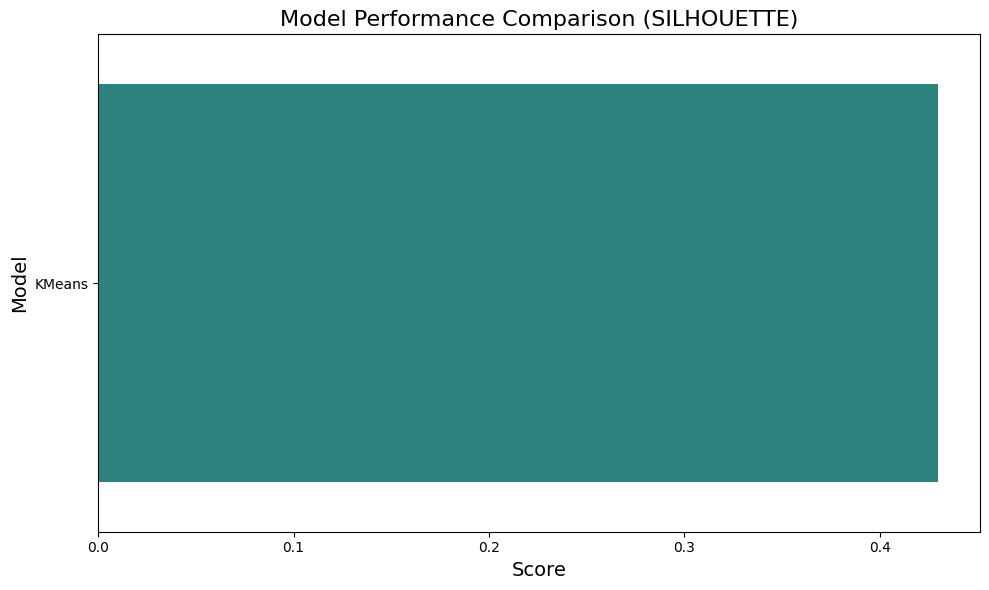


Best Model: KMeans with Score: 0.4299
Index(['reviews', 'overall_satisfaction', 'target'], dtype='object')

Model: KMeans | Silhouette Score: 0.4299

Cluster Summary (Mean, Std, Size) for reviews and target:
            reviews                        target                  
               mean        std  size         mean         std  size
Cluster                                                            
0         17.266667  23.044622   255   327.949020  114.800449   255
1          2.208333   6.331283    24  1206.708333  389.991692    24
2         29.434995  22.909901  3692    53.815276   20.043572  3692
3        136.546326  49.287897  1252    65.275559   25.573548  1252
4          1.666667   2.886751     3  3723.000000  432.666153     3
5         25.793062  24.398158  1672   127.427033   32.404212  1672


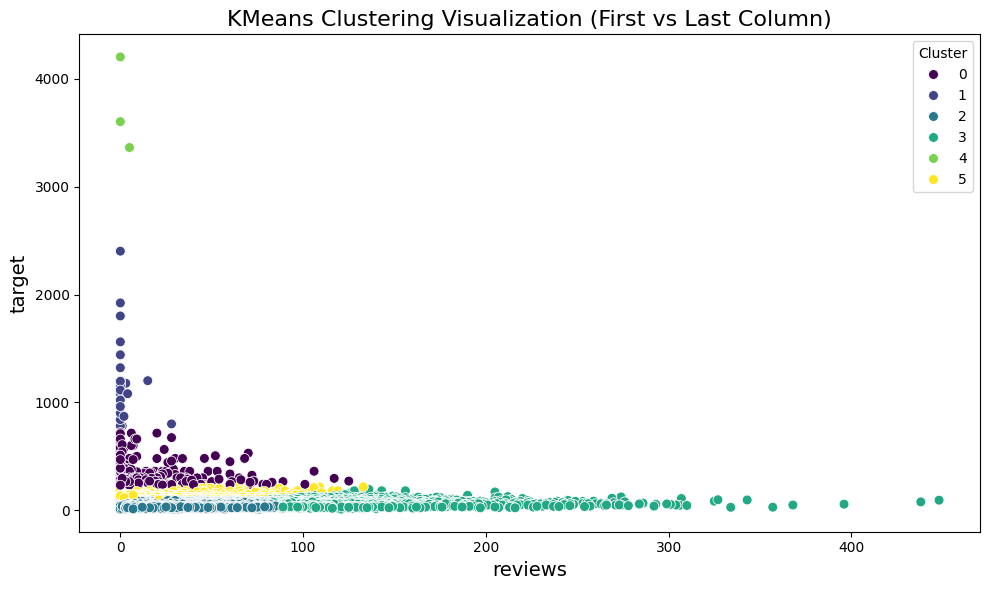


Cluster 2 Statistics for reviews and target:
           reviews       target
count  3692.000000  3692.000000
mean     29.434995    53.815276
std      22.909901    20.043572
min       0.000000    10.000000
25%       9.000000    36.000000
50%      24.000000    54.000000
75%      46.000000    71.000000
max      85.000000    92.000000


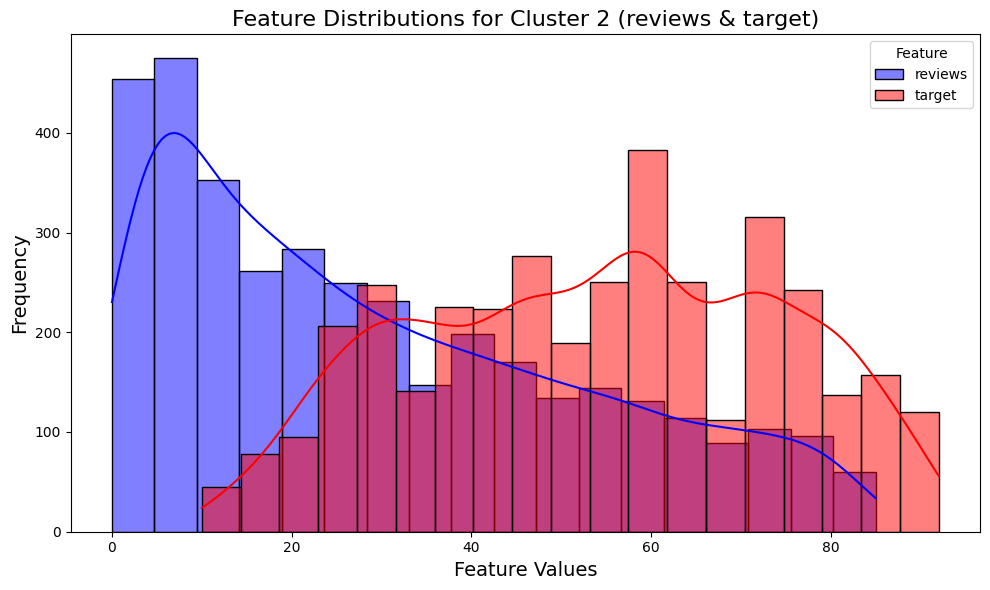


Cluster 0 Statistics for reviews and target:
          reviews      target
count  255.000000  255.000000
mean    17.266667  327.949020
std     23.044622  114.800449
min      0.000000  227.000000
25%      1.000000  240.000000
50%      8.000000  288.000000
75%     23.000000  361.000000
max    125.000000  721.000000


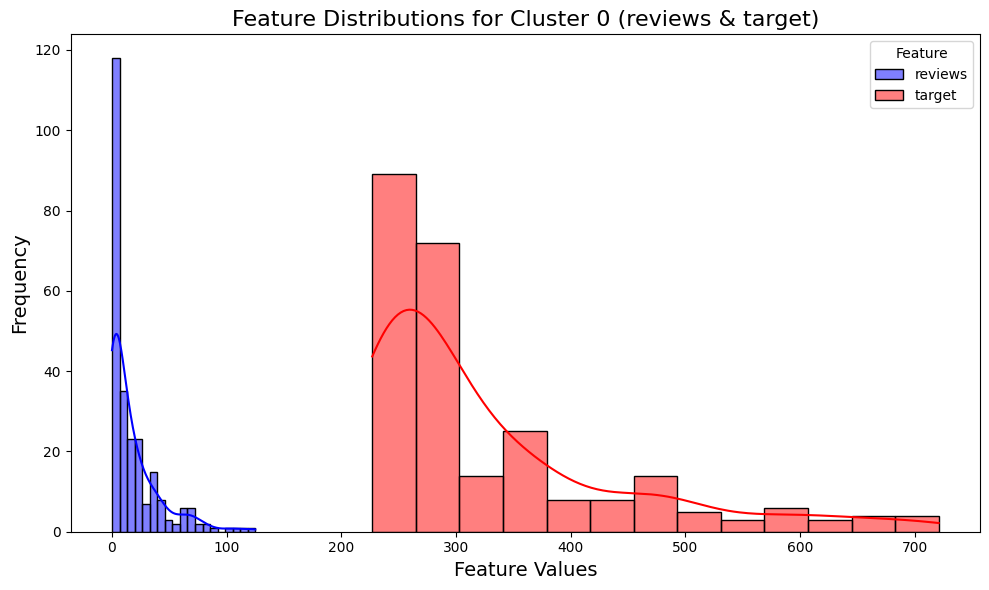


Cluster 5 Statistics for reviews and target:
           reviews       target
count  1672.000000  1672.000000
mean     25.793062   127.427033
std      24.398158    32.404212
min       0.000000    89.000000
25%       6.000000   102.000000
50%      17.000000   118.000000
75%      40.000000   144.000000
max     133.000000   227.000000


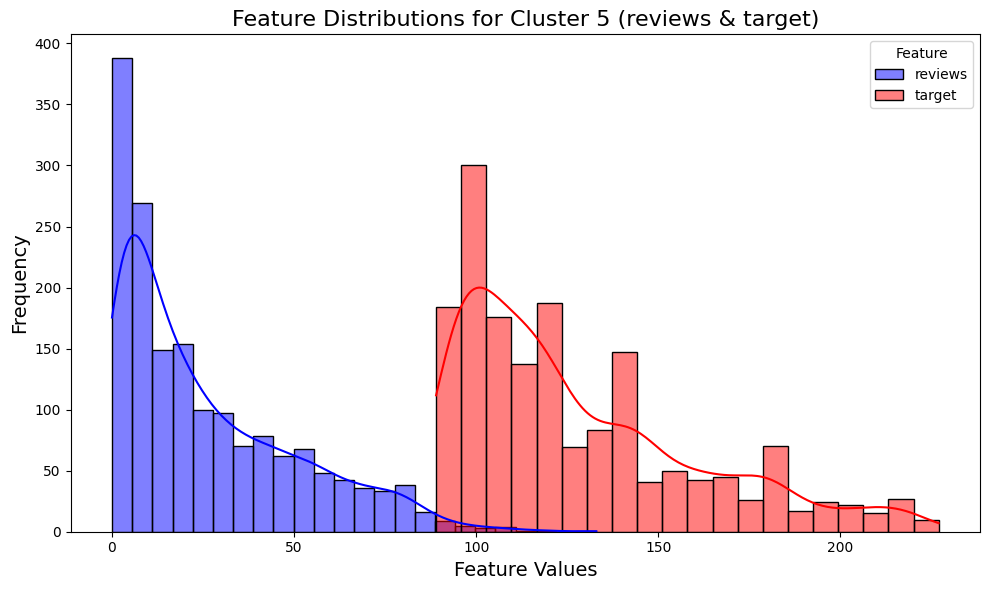


Cluster 3 Statistics for reviews and target:
           reviews       target
count  1252.000000  1252.000000
mean    136.546326    65.275559
std      49.287897    25.573548
min      80.000000    10.000000
25%     101.000000    48.000000
50%     123.000000    60.000000
75%     156.250000    78.000000
max     448.000000   193.000000


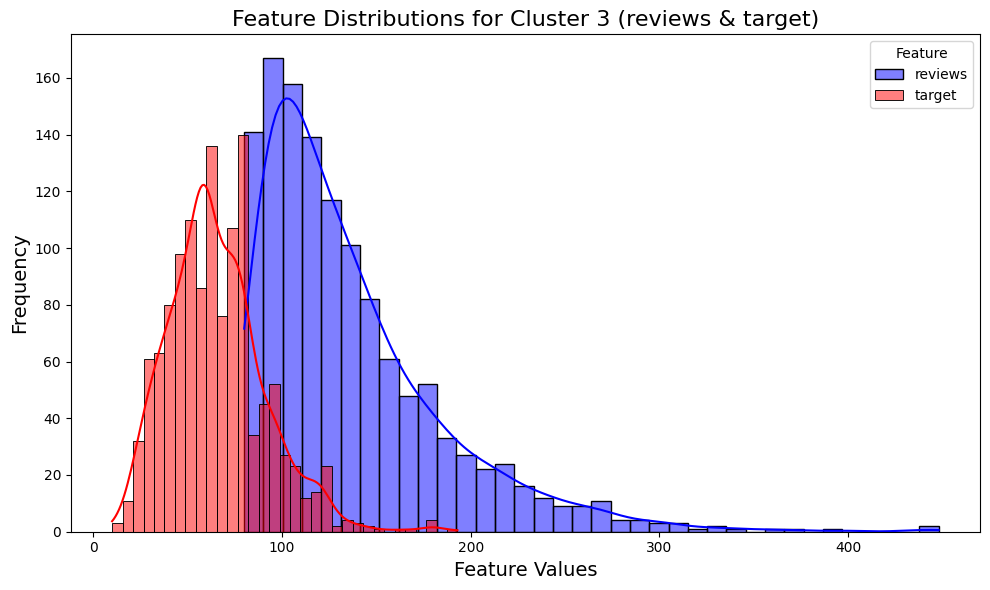


Cluster 1 Statistics for reviews and target:
         reviews       target
count  24.000000    24.000000
mean    2.208333  1206.708333
std     6.331283   389.991692
min     0.000000   781.000000
25%     0.000000   945.750000
50%     0.000000  1161.000000
75%     0.250000  1231.000000
max    28.000000  2402.000000


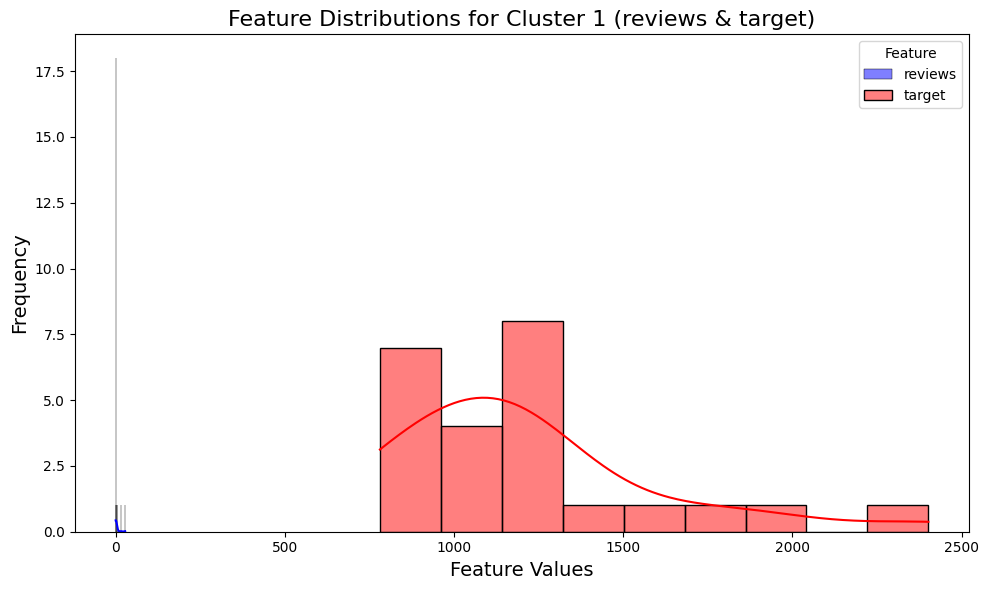


Cluster 4 Statistics for reviews and target:
        reviews       target
count  3.000000     3.000000
mean   1.666667  3723.000000
std    2.886751   432.666153
min    0.000000  3363.000000
25%    0.000000  3483.000000
50%    0.000000  3603.000000
75%    2.500000  3903.000000
max    5.000000  4203.000000


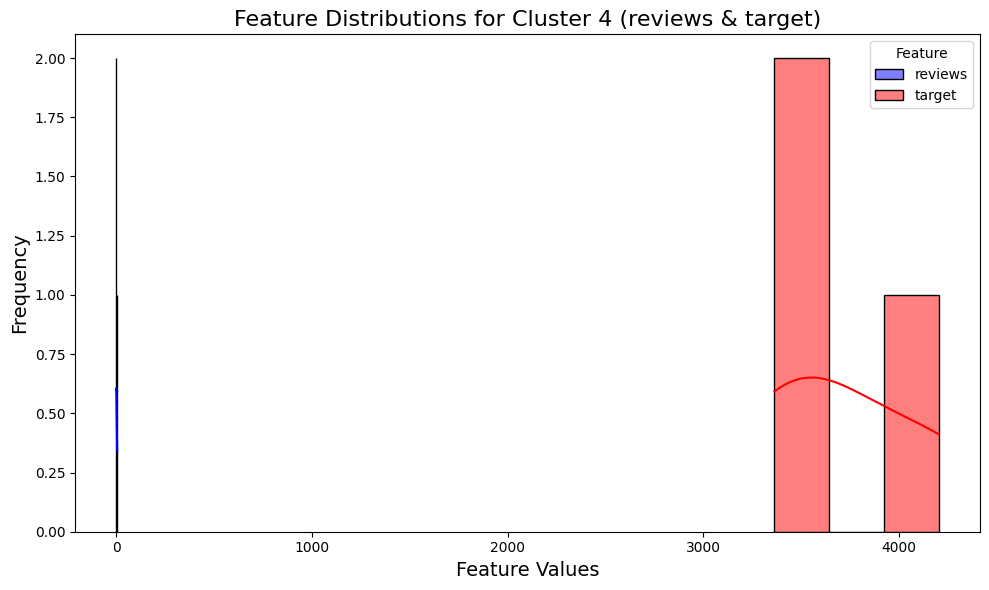

In [31]:
uautoML.report()